## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# Содержание проекта

[Шаг 1: подготовка данных](#step1)
- [Импорт библиотек](#step1_1)
- [Загрузка данных и ресемплирование](#step1_2)

[Шаг 2: Анализ](#step2)
- [Оцениваем тренд и сезонную компоненту](#step2_1)
- [Промежуточный вывод](#step2_last)

[Шаг 3: Обучение](#step3)
- [Создаем признаки](#step3_1)
- [Подбираем параметры скольжения и лага](#step3_2)
- [Случайный лес: обучение и подбор гиперпараметров](#step3_3)
- [Catboost: обучение](#step3_4)

[Шаг 4: Тестирование](#step4)
- [Модель случайного леса](#step4_1)
- [Модель Catboost](#step4_2)
- [Dummy модель среднего](#step4_3)
- [Dummy модель предыдущего значения](#step4_4)


[Выводы](#step_last)

<a id='step1'></a>

# 1. Подготовка

<a id='step1_1'></a>

## 1.1. Импорт библиотек

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import copy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import Pool, CatBoostRegressor
from lightgbm import LGBMRegressor

<a id='step1_2'></a>

## 1.2. Загрузка данных и ресемплирование

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

__Проверим общую информацию о данных__

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


__Оценим возможные пропуски__

In [4]:
data.isna().sum()

num_orders    0
dtype: int64

In [5]:
data = data.resample('1H').sum() # используем для обучения
data_daily = data.resample('1D').sum() # нужно для анализа

<a id='step2'></a>

# 2. Анализ

<a id='step2_1'></a>

## 2.1. Оценим тренд и сезонную компоненту

In [6]:
decomposed_daily = seasonal_decompose(data_daily)
decomposed_hourly = seasonal_decompose(data)

Text(0.5, 1.0, 'Рис.1: Тренд в количестве заказов такси на основании дневных данных и часовых колебаний')

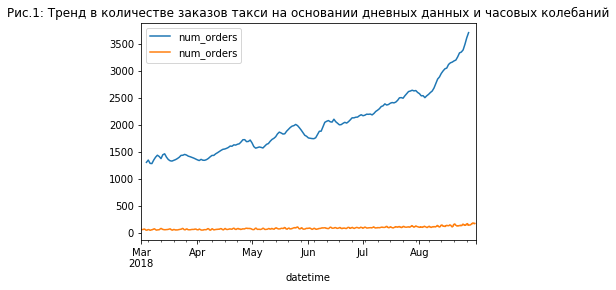

In [7]:
decomposed_daily.trend.plot(ax=plt.gca())
decomposed_hourly.trend.plot(ax=plt.gca())
plt.title('Рис.1: Тренд в количестве заказов такси на основании дневных данных и часовых колебаний')

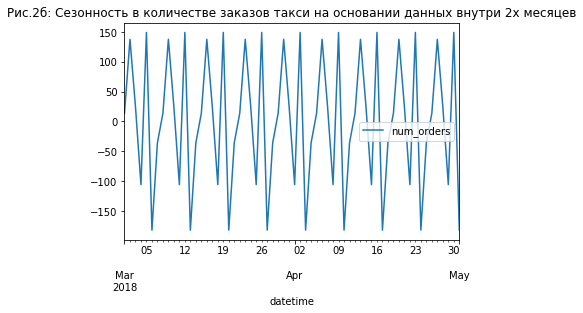

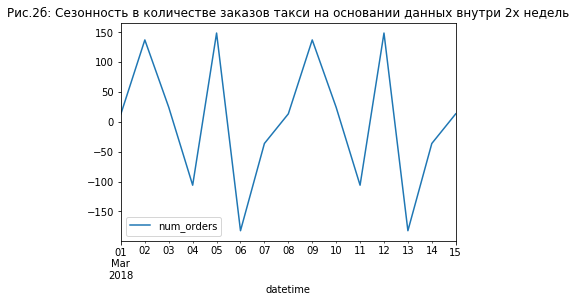

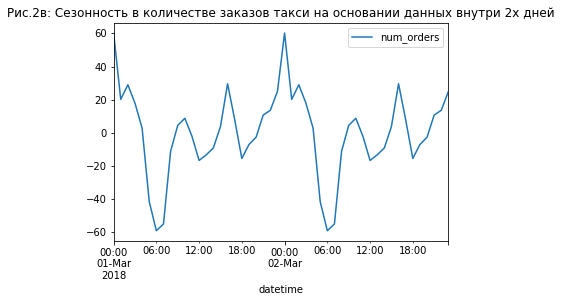

In [8]:
decomposed_daily.seasonal['2018-03-01':'2018-05-01'].plot(ax=plt.gca())
plt.title('Рис.2б: Сезонность в количестве заказов такси на основании данных внутри 2х месяцев')
plt.show()

decomposed_daily.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Рис.2б: Сезонность в количестве заказов такси на основании данных внутри 2х недель')
plt.show()

decomposed_hourly.seasonal['2018-03-01 00:00:00':'2018-03-02 23:00:00'].plot(ax=plt.gca())
plt.title('Рис.2в: Сезонность в количестве заказов такси на основании данных внутри 2х дней')
plt.show()

<a id='step2_last'></a>

## Промежуточный вывод

1. На рисунке 1 выше мы наблюдаем в периоде с марта по сентябрь 2018 года тренд на увеличение заказав такси.
2. На рисунках 2а, 2б, 2в мы также видим, что в заказах такси присутствует явная сезональность в зависимости от дня недели и от времени вызов в сутках. Причем есть как суточный так и недельный циклы.

А значит, что в моделях нам необходимо предусмотреть значение `roll` и `лаг` который смогли бы эту сезональность поймать. Поскольку мы прогнозируем заказ на следующий час на разумно установить и `roll` и `лаг` в 24 часа - по крайней мере начать обучения модели с этих параметров.

Недельный цикл для данной модели нам учитывать нет необходимости, поскольку модель только для предсказания на следующий час, а значит в суточных данных уже будет учтена вся информация о дне недели (с его пиками).

<a id='step3'></a>

# 3. Обучение

<a id='step3_1'></a>

## 3.1. Напишем функцию для создания признаков

In [9]:
def make_features(df, max_lag, rolling_mean_size):
    df_iterations = pd.DataFrame()
    df_iterations = copy.copy(df)
    df_iterations['year'] = df_iterations.index.year
    df_iterations['month'] = df_iterations.index.month
    df_iterations['day'] = df_iterations.index.day
    df_iterations['dayofweek'] = df_iterations.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_iterations[f'lag_%d' %lag] = df_iterations.iloc[:, 0].shift(lag)

    df_iterations['rolling_mean'] = df_iterations.iloc[:, 0].shift().rolling(rolling_mean_size).mean()
    
    return df_iterations

<a id='step3_2'></a>

## 3.2. На простой модели линейной регрессии подберем параметры "окна скольжения" и "лага"

In [10]:
comparison = pd.DataFrame({"lag": [], 
                           "roll": [],
                           "RMSE": []})

In [11]:
%%time

max_lag = 24 # 24 - из-за 24 часового цикла в вызовах такси
max_roll = 24

for lag in range(1, max_lag): #перебираем разные параметры и ниже сохраняем для будущего сравнения в comparison
    for roll in range(1, max_roll):
        data_iterations = pd.DataFrame()
        data_iterations = copy.copy(data) #поверхностное копирование, чтобы изначальные данные не менялись   
        
        data_iterations = make_features(data_iterations, lag, roll)
        
        train, valid = train_test_split(data_iterations, shuffle=False, test_size=0.1) #здесь для валидации возьмем 10% данных
        train = train.dropna()
        
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_valid = valid.drop(['num_orders'], axis=1)
        target_valid = valid['num_orders']
        
        model_LR = LinearRegression()
        model_LR.fit(features_train, target_train)
        prediction_LR = model_LR.predict(features_valid)
        
        comparison = comparison.append({"lag": lag, 
                                        "roll": roll,
                                        "RMSE": mean_squared_error(target_valid, prediction_LR)**0.5},
                                        ignore_index=True)

CPU times: user 52.8 s, sys: 39.8 s, total: 1min 32s
Wall time: 1min 32s


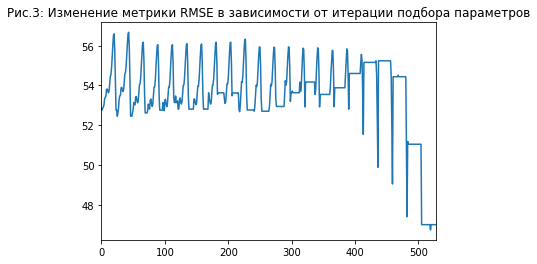

In [12]:
comparison['RMSE'].plot()
plt.title('Рис.3: Изменение метрики RMSE в зависимости от итерации подбора параметров')
plt.show()

In [13]:
print("Таблица №1: минимальное RMSE при параметрах скольжения")
print("------------------------------------------------------")
print(comparison[comparison['RMSE'] == comparison['RMSE'].min()])

Таблица №1: минимальное RMSE при параметрах скольжения
------------------------------------------------------
      lag  roll       RMSE
519  23.0  14.0  46.739099


__Собственно как мы и ожидали - действительно необходимо учитывать 23 часа лага и 14 часовую среднюю для того, чтобы улучшить точность прогнозирования. Применим эти выводы к более сложным моделям далее, а ниже сохраним найденные параметры в выборках.__

In [21]:
data = make_features(data,
              int(comparison[comparison['RMSE'] == comparison['RMSE'].min()].iloc[0,0]), 
              int(comparison[comparison['RMSE'] == comparison['RMSE'].min()].iloc[0,1]))

In [22]:
train, test = train_test_split(data, shuffle=False, test_size=0.1) #10% данных для теста, согласно условию
train = train.dropna()
        
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

<a id='step3_3'></a>

## 3.3. Обучим модель случайного леса и подберем гиперпараметры

In [41]:
param_grid = {
    "n_estimators": [30, 50, 100],
    "max_depth": [5, 10, 15]
}

In [42]:
model_forest = GridSearchCV(estimator = RandomForestRegressor(random_state = 123), 
                            param_grid = param_grid, 
                            cv = TimeSeriesSplit(n_splits=3), 
                            n_jobs = -1, 
                            scoring = 'neg_mean_squared_error',
                           )

In [43]:
%%time

model_forest.fit(features_train, target_train)

CPU times: user 43.1 s, sys: 0 ns, total: 43.1 s
Wall time: 43.3 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=123,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,

<a id='step3_4'></a>

## 3.4. Обучим модель `catboost`

In [26]:
model_cbr = CatBoostRegressor(iterations=1000, learning_rate = 0.1, depth=10, loss_function='RMSE')
model_cbr.fit(features_train, target_train, verbose=200)

0:	learn: 37.2450780	total: 253ms	remaining: 4m 12s
200:	learn: 10.1865689	total: 34.3s	remaining: 2m 16s
400:	learn: 4.4101472	total: 1m 8s	remaining: 1m 42s
600:	learn: 2.0275008	total: 1m 43s	remaining: 1m 8s
800:	learn: 0.9739953	total: 2m 19s	remaining: 34.6s
999:	learn: 0.4855517	total: 2m 53s	remaining: 0us


<a id='step4'></a>

# 4. Тестирование

<a id='step4_1'></a>

## 4.1. В модели случайного леса

In [44]:
forest_prediction = model_forest.predict(features_test)
print("RMSE-модели случайного леса:", mean_squared_error(target_test, forest_prediction)**0.5)

RMSE-модели случайного леса: 46.601011973873206


<a id='step4_2'></a>

## 4.2. В модели `catboost`

In [28]:
prediction_cbr = model_cbr.predict(features_test)
print("RMSE-модели catboost:", mean_squared_error(target_test, prediction_cbr)**0.5)

RMSE-модели catboost: 46.24502324034806


<a id='step4_3'></a>

## 4.3. "Модель среднего" 

In [29]:
predictions_average = np.ones(target_test.shape) * target_train.median()

In [30]:
print("RMSE-простого среднего:", mean_squared_error(target_test, predictions_average)**0.5)

RMSE-простого среднего: 87.15277582981295


<a id='step4_4'></a>

## 4.4. "Модель предыдущего значения"

In [31]:
pred_previous = target_test.shift(fill_value=train.iloc[len(target_train)-1, 0]) 
print("RMSE-предыдущего значения:", mean_squared_error(target_test, pred_previous)**0.5)

RMSE-предыдущего значения: 58.856486242815066


<a id='step_last'></a>

# Выводы
___
1. Для того, чтобы корректно прогнозировать потребность в машинах такси на следующий час около аэропорта мы оценили суточную цикличность (сезонность) и учли её при формировании признаков. `23-часа данных и 14-часовое скольжение` оказывают наибольший эффект на точность прогноза с точки зрения минимизации разброса `rmse`.
2. Мы составили 2 модели - `случайный лес` (с перебором параметров и кросс-валидацией) и `catboost`, чтобы спрогнозировать потребность в машинах. Модель catboost справляется немного лучше случайного леса. При этом в модели catboost, при переборе значений количества итераций 100, 1000, 2000 качество модели почти не меняется. Здесь оставил только 1000 итераций, для экономии времени выполнения кода.
3. Обе модели справляются с прогнозированием лучше, чем `dummy-модели среднего` и `предыдущего значения`.